In [2]:
!source activate pytorch

In [4]:
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 78.3 MB/s eta 0:00:00m eta 0:00:010:0101


In [108]:
!pip install torchdistill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 42.1 MB/s eta 0:00:00m eta 0:00:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl size=110812 sha256=25dde4c7c0214c0ef920858cf44a88f34f83a9f85c4ad585e7debd360e91540a
  Stored in directory: /home/ubuntu/.cache/pip/wheels/58/e6/f9/f87c8f8be098b51b616871315318329cae12cdb618f4caac93
Successfully built pycocotools


In [33]:
import yaml
import json
import torch
from torch.utils.data import Dataset
from torch import nn
import plotly.express as px

In [19]:
# vocab.py

class Vocab:
    def __init__(self, tokens): 
        special_tokens = ["PAD", "SOS", "EOS"]
        self.tokens = tokens + special_tokens
        self.token_ix = {t:i for i, t in enumerate(self.tokens)}
        self.ix_token = {i:t for i,t in enumerate(self.tokens)}

    def encode(self, seq, max_len=None):
        encoded = [self.token_ix["SOS"]] + [self.token_ix[t] for t in seq] + [self.token_ix["EOS"]]
        if max_len:
            if len(encoded) < max_len:
                encoded += [self.token_ix["PAD"]]*(max_len-len(encoded))
                
        return encoded
                
    def decode(self, seq):
        return [self.ix_token[t] for t in seq]
    
    def __len__(self):
        return len(self.tokens)
    

class ProteinVocab(Vocab):
    def __init__(self):
        # 20 amino acids
        tokens = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']
        super().__init__(tokens)


class SMILEVocab(Vocab):
    def __init__(self):
        tokens = ['#','(',')','+','-','.','/','1','2','3','4','5','6','7','8','=','@',
                  'A','B','C','F','G','H','I','K','L','M','N','O','P','S','T','V','W','Z',
                  '[','\\',']','a','b','d','e','g','i','l','n','o','r','s','t','u']
        super().__init__(tokens)


class DrugBankDB:
    def __init__(self):
        self.id_to_smile = json.load(open("../data/databankid_to_smile.json", "r"))

    def get_smile_from_id(self, id):
        return self.id_to_smile[id]


class UniProtDB:
    def __init__(self):
        self.id_to_amino_seq = json.load(open("../data/uniprotid_to_seq.json", "r"))

    def get_amino_seq_from_id(self, id):
        return self.id_to_amino_seq[id]

In [18]:
# models/pretraining.py

class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1, dropout=0, bidirectional=False):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.bidirectional = bidirectional
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True, bidirectional=bidirectional)
        self.out = nn.Linear(hidden_size*2 if self.bidirectional else hidden_size, vocab_size)
        
        
    def forward(self, x, hidden=None):
        x = self.embedding(x)
        x, hidden = self.gru(x, hidden)
        x = self.out(x[:, -1])
        return x, hidden

In [8]:
# models/transformer.py

class PositionalEncoding(nn.Module):
    """Sinusoidal Positional Encoding
    """
    def __init__(self, d_model, max_len):
        super().__init__()
        self.d_model = d_model
        self.max_len = max_len
        
        positions = torch.arange(0, max_len).unsqueeze(1)

        frequencies = 10000**(torch.arange(0, d_model, 2)/d_model)
        
        self.encoding = torch.zeros(max_len, d_model)

        self.encoding[:, 1::2] = torch.sin(positions / frequencies)
        self.encoding[:, 0::2] = torch.cos(positions / frequencies)

    def forward(self, x):
        seq_len = x.shape[1]

        x = x  + self.encoding[:seq_len].to(x.device)

        return x


class CrossLayer(nn.Module):
    def __init__(self, embed_size, n_head, hidden_size, dropout):
        super().__init__()
        self.embed_size = embed_size
        self.n_head = n_head
        self.hidden_size = hidden_size
        self.dropout = dropout

        self.self_attention_encoder_1 = nn.TransformerEncoderLayer(
            d_model=embed_size,
            nhead=n_head,
            dim_feedforward=hidden_size,
            dropout=dropout,
            batch_first=True
        )

        self.self_attention_encoder_2 = nn.TransformerEncoderLayer(
            d_model=embed_size,
            nhead=n_head,
            dim_feedforward=hidden_size,
            dropout=dropout,
            batch_first=True
        )

        self.cross_attention1 = nn.MultiheadAttention(embed_dim=embed_size, num_heads=n_head, batch_first=True)
        self.cross_attention2 = nn.MultiheadAttention(embed_dim=embed_size, num_heads=n_head, batch_first=True)


    def forward(self, x1, x2):

        # x1 -> (N, S)
        # x2 -> (N, S)

        cross_alignment_1, _ = self.cross_attention1(
            query=x2,
            key=x1,
            value=x1
        )

        cross_alignment_2, _ = self.cross_attention2(
            query=x1,
            key=x2,
            value=x2
        )

        alignment_1 = self.self_attention_encoder_1(cross_alignment_1)
        alignment_2 = self.self_attention_encoder_2(cross_alignment_2)

        return alignment_1, alignment_2


class CrossNet(nn.Module):
    def __init__(self, hidden_size, n_head, num_layers, dropout, mode="classification"):
        super().__init__()

        self.hidden_size = hidden_size
        self.n_head = n_head
        self.num_layers = num_layers
        self.dropout = dropout
        self.is_contrastive = mode=="contrastive"

        self.drug_embedding = None
        self.protein_embedding = None

        self.cross_layers = nn.ModuleList([
            CrossLayer(embed_size=64, n_head=n_head, hidden_size=hidden_size, dropout=dropout) for _ in range(num_layers)
        ])

        if not self.is_contrastive:
            self.out = nn.Linear(64*2, 2)


        self.positional_encoding = PositionalEncoding(d_model=64, max_len=20000)


    def set_drug_protein_embeddings(self, drug, protein):
        self.drug_embedding = drug
        self.protein_embedding = protein

        self.drug_embedding.requires_grad = False
        self.protein_embedding.requires_grad = False


    def forward(self, x):
        x1, x2 = x
        N = x1.shape[0]

        x1 = self.drug_embedding(x1) # (N, S, E)
        x2 = self.protein_embedding(x2) # (N, S, E)

        x1 = self.positional_encoding(x1)
        x2 = self.positional_encoding(x2)

        for layer in self.cross_layers:
            x1, x2 = layer(x1, x2)


        # x1 (N, S, 64)
        # x2 (N, S, 64)

        x1 = x1.mean(1) # (N, 64)
        x2 = x2.mean(1) # (N, 64)

        if self.is_contrastive: 
            return x1, x2
        
        else:
            x = torch.cat([x1, x2], 1) # (N, 64*2)
            x = self.out(x)

            return x


class Transformer(nn.Module):
    def __init__(self, hidden_size, n_head, num_layers, dropout, mode=None):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

        self.drug_embedding = None
        self.protein_embedding = None

        self.transformer = nn.Transformer(
            d_model=64,
            nhead=n_head,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_size,
            dropout=dropout,
            batch_first=True,
        )

        self.positional_encoding = PositionalEncoding(d_model=64, max_len=20000)

        self.out = nn.Linear(64, 2)


    def set_drug_protein_embeddings(self, drug, protein):
        self.drug_embedding = drug
        self.protein_embedding = protein

        self.drug_embedding.requires_grad = False
        self.protein_embedding.requires_grad = False


    def forward(self, x):
        x1, x2 = x
        
        N = x1.shape[0]

        x1 = self.drug_embedding(x1) # (N, S, E)
        x2 = self.protein_embedding(x2) # (N, S, E)

        x1 = self.positional_encoding(x1)
        x2 = self.positional_encoding(x2)

        x = self.transformer(x1, x2)

        x = x.mean(1)

        out = self.out(x)
        
        return out


def build(name, config):
    hidden_size = config["HIDDEN_SIZE"]
    num_layers = config["NUM_LAYERS"]
    dropout = config["DROPOUT"]
    num_heads = config["NUM_HEADS"]
    mode = "contrastive" if bool(config["CONTRASTIVE"]) else "classification"

    
    if "cross" in name:
        net = CrossNet(hidden_size=hidden_size, n_head=num_heads, num_layers=num_layers, dropout=dropout, mode=mode)

    else:
        net = Transformer(hidden_size=hidden_size, n_head=num_heads, num_layers=num_layers, dropout=dropout)

    return net
    

In [20]:
amino_vocab = ProteinVocab()
smile_vocab = SMILEVocab()

In [28]:
pretrained_smile_embeddings = GRUModel(
    vocab_size=len(smile_vocab),
    embed_size=64,
    hidden_size=128,
    num_layers=1,
    dropout=0,
    bidirectional=False
)

pretrained_amino_embeddings = GRUModel(
    vocab_size=len(amino_vocab),
    embed_size=64,
    hidden_size=128,
    num_layers=1,
    dropout=0,
    bidirectional=False
)

pretrained_smile_embeddings.load_state_dict(torch.load("../checkpoints/pretraining/smile_gru.pth"))
pretrained_amino_embeddings.load_state_dict(torch.load("../checkpoints/pretraining/protein_gru.pth"))

pretrained_smile_embeddings = pretrained_smile_embeddings.embedding
pretrained_amino_embeddings = pretrained_amino_embeddings.embedding

In [29]:
transformer_config = yaml.safe_load(open("../config/transformer/transformer_classification_baseline.yml", "r"))
cross_alignet_config = yaml.safe_load(open("../config/transformer/crosstransformer_contrastive_baseline.yml", "r"))

In [30]:
transformer = build("transformer", transformer_config)
cross_alignet = build("cross", cross_alignet_config)

transformer.set_drug_protein_embeddings(
    pretrained_smile_embeddings,
    pretrained_amino_embeddings
)

cross_alignet.set_drug_protein_embeddings(
    pretrained_smile_embeddings,
    pretrained_amino_embeddings
)

In [31]:
transformer.drug_embedding

Embedding(54, 64)

In [32]:
transformer_checkpoint = torch.load("../checkpoints/classification/transformer-classification-baseline/model.pt", map_location="cpu")
cross_alignet_checkpoint = torch.load("../checkpoints/classification/crosstransformer-contrastive-baseline/model.pt", map_location="cpu")

transformer_state_dict = transformer_checkpoint["model"]
cross_alignet_state_dict = cross_alignet_checkpoint["model"]

print(f"Test Accuracy (Transformer) @ (epoch {transformer_checkpoint['epoch']:3}) -> {transformer_checkpoint['accuracy']}")
print(f"Test Accuracy (Cross-AlNet) @ (epoch {cross_alignet_checkpoint['epoch']:3}) -> {cross_alignet_checkpoint['accuracy']}")


transformer.load_state_dict(transformer_state_dict)
cross_alignet.load_state_dict(cross_alignet_state_dict)

transformer.eval()
cross_alignet.eval()

transformer.requires_grad_(False)
cross_alignet.requires_grad_(False)

Test Accuracy (Transformer) @ (epoch  59) -> 0.9147695302963257
Test Accuracy (Cross-AlNet) @ (epoch 248) -> 0.8982758522033691


CrossNet(
  (cross_layers): ModuleList(
    (0-1): 2 x CrossLayer(
      (self_attention_encoder_1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0, inplace=False)
        (dropout2): Dropout(p=0, inplace=False)
      )
      (self_attention_encoder_2): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (drop

In [34]:
# data.py

class DTIDataset(Dataset):
    def __init__(self, train, smile_vocab, protein_vocab, smile_embedding, amino_embedding, device="cuda"):
        self.device = device
        if train:
            self.x = json.load(open("../data/dti_train_x.json", "r"))
            self.y = json.load(open("../data/dti_train_y.json", "r"))
        else:
            self.x = json.load(open("../data/dti_test_x.json", "r"))
            self.y = json.load(open("../data/dti_test_y.json", "r"))

        self.train = train
        self.drugbankdb = DrugBankDB()
        self.uniprotdb = UniProtDB()
        self.smile_vocab = smile_vocab
        self.protein_vocab = protein_vocab
        self.smile_embedding = smile_embedding
        self.amino_embedding = amino_embedding

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        row = self.x[idx]
        
        drug = row["drug"]
        target = row["target"]
        
        drug = self.drugbankdb.get_smile_from_id(drug)
        drug = torch.Tensor(self.smile_vocab.encode(drug)).long().to(self.device) # get tokenized
        # drug = self.smile_embedding(drug).mean(1).squeeze() # get embeddings
        
        target = self.uniprotdb.get_amino_seq_from_id(target)
        target = torch.Tensor(self.protein_vocab.encode(target)).long().to(self.device) # get tokenized
        # target = self.amino_embedding(target).mean(1).squeeze() # get embeddings
        
        y = self.y[idx]

        drug = drug.to(self.device)
        target = target.to(self.device)
        
        return drug, target, y


In [35]:
test = DTIDataset(
    train=False,
    smile_vocab=smile_vocab,
    protein_vocab=amino_vocab,
    smile_embedding=pretrained_smile_embeddings,
    amino_embedding=pretrained_amino_embeddings,
    device="cpu"
)

In [37]:
drug, amino, label = test[0]

In [39]:
label

0

In [41]:
drug.shape

torch.Size([28])

In [42]:
amino.shape

torch.Size([462])

In [51]:
print("Amino Sequence \n", "".join(amino_vocab.decode(amino.tolist()[1:-1])))

Amino Sequence 
 MNTSAPPAVSPNITVLAPGKGPWQVAFIGITTGLLSLATVTGNLLVLISFKVNTELKTVNNYFLLSLACADLIIGTFSMNLYTTYLLMGHWALGTLACDLWLALDYVASNASVMNLLLISFDRYFSVTRPLSYRAKRTPRRAALMIGLAWLVSFVLWAPAILFWQYLVGERTVLAGQCYIQFLSQPIITFGTAMAAFYLPVTVMCTLYWRIYRETENRARELAALQGSETPGKGGGSSSSSERSQPGAEGSPETPPGRCCRCCRAPRLLQAYSWKEEEEEDEGSMESLTSSEGEEPGSEVVIKMPMVDPEAQAPTKQPPRSSPNTVKRPTKKGRDRAGKGQKPRGKEQLAKRKTFSLVKEKKAARTLSAILLAFILTWTPYNIMVLVSTFCKDCVPETLWELGYWLCYVNSTINPMCYALCNKAFRDTFRLLLLCRWDKRRWRKIPKRPGSVHRTPSRQC


In [53]:
print("SMILEs Sequence of Drug \n", "".join(smile_vocab.decode(drug.tolist()[1:-1])))

SMILEs Sequence of Drug 
 N1C2=CC=CC=C2N=C1C1=CSC=N1


In [103]:
transformer_prediction = transformer((drug.unsqueeze(0), amino.unsqueeze(0)))
print(transformer_prediction.softmax(-1))
print(transformer_prediction.argmax(-1))

tensor([[0.9068, 0.0932]])
tensor([0])


In [104]:
def get_predictions_from_similarity(repr1, repr2, thresh=.5):
    repr1 = torch.nn.functional.normalize(repr1, p=2, dim=1) # l2 norm
    repr2 = torch.nn.functional.normalize(repr2, p=2, dim=1) # l2 norm 
    distance = torch.abs(torch.nn.functional.cosine_similarity(repr1, repr2)) # (N)
    
    pred = (distance > thresh).long()

    return pred, distance

In [105]:
contrastive_prediction, distance = get_predictions_from_similarity(*cross_alignet((drug.unsqueeze(0), amino.unsqueeze(0))))

In [107]:
contrastive_prediction, (1-distance)

(tensor([0]), tensor([0.9944]))

In [120]:
from torchdistill.core.forward_hook import ForwardHookManager
forward_hook_manager = ForwardHookManager("cpu")
forward_hook_manager.add_hook(transformer, 'transformer.decoder.', requires_input=True, requires_output=True)

In [121]:
transformer_prediction = transformer((drug.unsqueeze(0), amino.unsqueeze(0)))
print(transformer_prediction.softmax(-1))
print(transformer_prediction.argmax(-1))

tensor([[0.9068, 0.0932]])
tensor([0])


In [122]:
io_dict = forward_hook_manager.pop_io_dict()
print(io_dict.keys())

dict_keys(['transformer'])


In [134]:
io_dict["transformer"]["output"].shape

torch.Size([1, 462, 64])

In [133]:
dataloader = torch.utils.data.DataLoader(test, batch_size=128)

fpr, tpr =  


AttributeError: 'tuple' object has no attribute 'shape'

In [135]:
def patch_attention(m):
    forward_orig = m.forward

    def wrap(*args, **kwargs):
        kwargs["need_weights"] = True
        kwargs["average_attn_weights"] = False

        return forward_orig(*args, **kwargs)

    m.forward = wrap
    
class SaveOutput:
    def __init__(self):
        self.outputs = []

    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out[1])

    def clear(self):
        self.outputs = []

In [147]:
transformer.transformer.decoder.layers[0].multihead_attn

MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
)

In [148]:
save_output = SaveOutput()
patch_attention(transformer.transformer.decoder.layers[0].multihead_attn)
transformer.transformer.decoder.layers[0].multihead_attn.register_forward_hook(save_output)
transformer_prediction = transformer((drug.unsqueeze(0), amino.unsqueeze(0)))

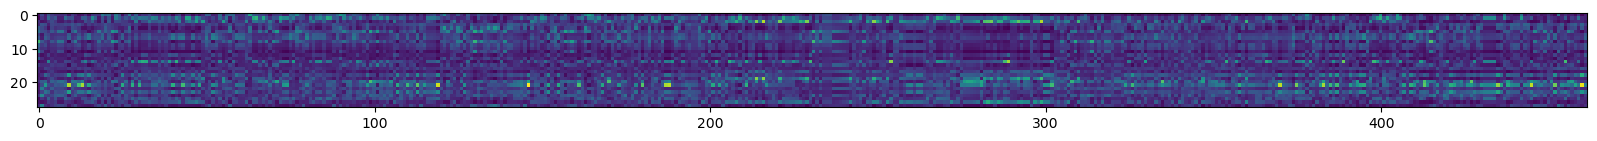

In [203]:
plt.figure(figsize=(20, 14))
plt.imshow(save_output.outputs[0][0, 0].T)

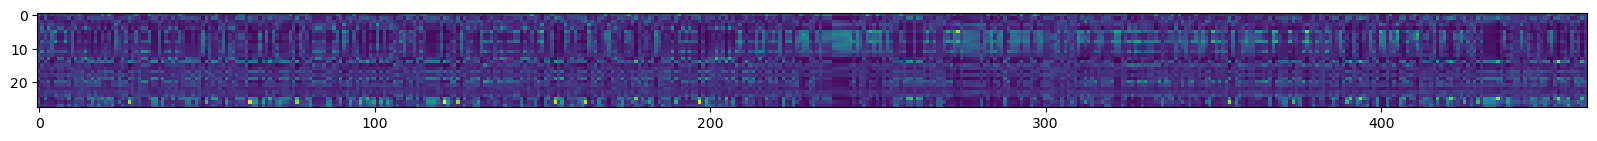

In [204]:
plt.figure(figsize=(20, 14))
plt.imshow(save_output.outputs[0][0, 1].T)

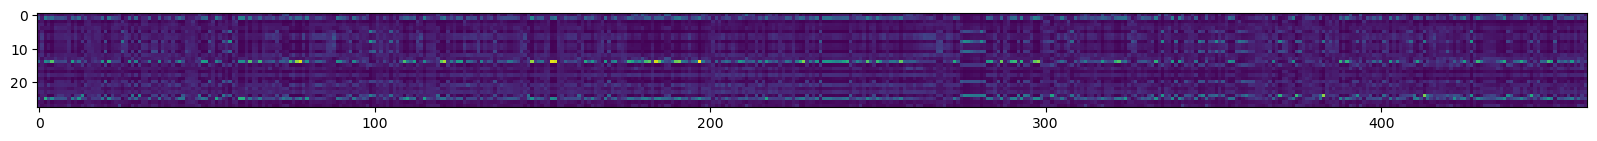

In [205]:
plt.figure(figsize=(20, 14))
plt.imshow(save_output.outputs[0][0, 2].T)

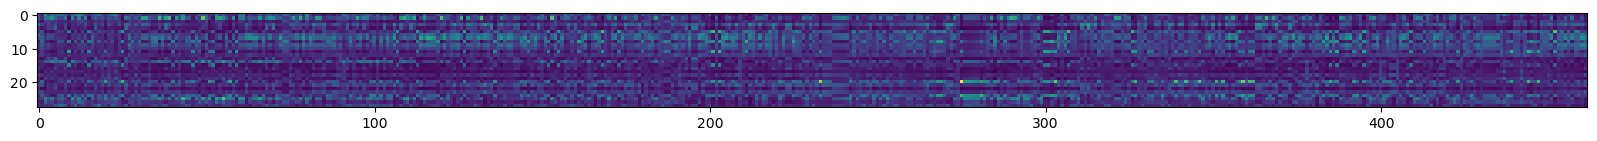

In [206]:
plt.figure(figsize=(20, 14))
plt.imshow(save_output.outputs[0][0, 3].T)

In [250]:
save_output = SaveOutput()
patch_attention(transformer.transformer.decoder.layers[0].self_attn)
transformer.transformer.decoder.layers[0].self_attn.register_forward_hook(save_output)
transformer_prediction = transformer((drug.unsqueeze(0), amino.unsqueeze(0)))

In [254]:
save_output.outputs[0][0].shape

torch.Size([4, 462, 462])

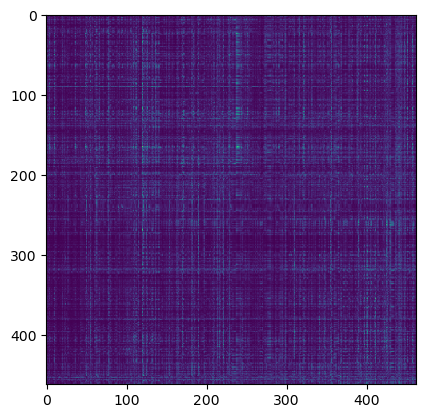

In [227]:
plt.imshow(save_output.outputs[0][0].min(0)[0])

In [237]:
save_output = SaveOutput()
patch_attention(transformer.transformer.encoder.layers[0].self_attn)
transformer.transformer.encoder.layers[0].self_attn.register_forward_hook(save_output)
transformer_prediction = transformer((drug.unsqueeze(0), amino.unsqueeze(0)))

In [238]:
save_output.outputs

[]

In [249]:
save_output.outputs

[]

In [239]:
import networkx

In [240]:
import matplotlib.pyplot as plt

In [248]:
!pip install bertviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 87.2 MB/s eta 0:00:000m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 771.9/771.9 kB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 93.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.9 MB/s eta 0:00:000m eta 0:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.0 MB/s eta 0:00:00


In [259]:
from bertviz import head_view

In [306]:
def visualize_attention_map(drug, target, model="transformer", layer=1, head=1, max_display=50):
    save_output = SaveOutput()

    if model == "transformer":
        patch_attention(transformer.transformer.decoder.layers[layer-1].multihead_attn)
        transformer.transformer.decoder.layers[layer-1].multihead_attn.register_forward_hook(save_output)
        transformer_prediction = transformer((drug.unsqueeze(0), target.unsqueeze(0)))
        
    attention_map = save_output.outputs[0][:, :, :max_display, :max_display].unsqueeze(1)
    print(attention_map.shape)
    return head_view(cross_attention=attention_map, encoder_tokens=smile_vocab.decode(drug.tolist())[:max_display], decoder_tokens=amino_vocab.decode(target.tolist())[:max_display], html_action='return').data



In [307]:
test[0][0].shape


torch.Size([28])

In [308]:
open('viz2.html', 'w').write(visualize_attention_map(test[0][0], test[0][1], layer=2))

torch.Size([1, 1, 4, 50, 28])


257015

In [309]:
!pip install pytorch-ignite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 14.7 MB/s eta 0:00:00


In [311]:
from ignite.contrib.metrics import ROC_AUC


In [317]:
# utils.py

def dataloader_collate_fn(data):
    """
    Pad (x1, x2) in data to same length in batch
    """

    x1, x2, y = zip(*data)

    y = torch.Tensor(list(y))

    lengths_x1 = [len(x) for x in x1]
    lengths_x2 = [len(x) for x in x2]

    max_len_x1 = max(lengths_x1)
    max_len_x2 = max(lengths_x2)

    batch_size = len(lengths_x1)

    x1_padded = torch.zeros(batch_size, max_len_x1).fill_(51)
    x2_padded = torch.zeros(batch_size, max_len_x2).fill_(21) # 21 is the <PAD> token in the amino acids vocab

    for i, seq in enumerate(x1):
        end = lengths_x1[i]
        x1_padded[i, :end] = seq[:end]

    for i, seq in enumerate(x2):
        end = lengths_x2[i]
        x2_padded[i, :end] = seq[:end]


    x1_padded = x1_padded.long()
    x2_padded = x2_padded.long()


    return x1_padded, x2_padded, y

In [1]:
dataloader = torch.utils.data.DataLoader(test, batch_size=, collate_fn=dataloader_collate_fn)

NameError: name 'torch' is not defined

In [2]:
roc_auc = ROC_AUC()

y_pred = []
y_true = []

with torch.no_grad():
    for x1, x2, y in dataloader:
        x1 = x1.to("cuda")
        x2 = x2.to("cuda")
        y = y.to("cuda")
        
        p = transformer((x1, x2)).softmax(-1) # (N, 2)
        p = p[:, 1] # get prob of being 1
        roc_auc.update((p, y))
        
        y_pred.append(p)
        y_true.append(y)

roc_auc_value = roc_auc.compute()

y_pred = torch.cat(y_pred, dim=0)
y_true = torch.cat(y_true, dim=0)

fpr, tpr, thresholds = roc_curve(y_true.cpu().numpy(), y_pred.cpu().numpy())

print(roc_auc_value)


NameError: name 'ROC_AUC' is not defined